# figure 4 vlz

- kernel: r_env, R 4.1.3
- date: 2023-12-28

## load

In [ ]:
library(tidyverse)
library(logging)
library(ggpubr)
library(ggsci)
library(patchwork)
library(Seurat)

source('../../stage2/scripts/r_funcs.r')

theme_set(theme_pubr())
logging::basicConfig()
options(warn = -1)

outdir <- '../figures/fig4'
create_dir(outdir)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Attaching SeuratObject



In [ ]:
f_pat_gp <- '../tables/patient_info_v2.tsv'
gp <- 'response'
gp_lvls$response <- c('R', 'PR')
gp_comp_map$response <- list(
  c('R-pre', 'R-post'),
  c('PR-pre', 'PR-post'),
  c('R-pre', 'PR-pre'),
  c('R-post', 'PR-post')
)
gp_comp_diff_map$response <- list(c('R', 'PR'))
gp_comp_map_pre$response <- list(c('R-pre', 'PR-pre'))
comb_order <- c('R-pre', 'R-post', 'PR-pre', 'PR-post')

In [ ]:
celltype_map <- list(
    'T_MKI67' = c('T_Prolif')
)

cell_state_map <- list(
    'cytotoxic' = c('CD8_ANXA1', 'CD8_CCL5', 'CD8_CX3CR1', 'CD8_FOS', 'CD8_GZMK', 'CD8_KLRB1'),
    'exhausted' = c('CD4_CXCL13', 'CD8_CXCL13', 'CD8_TYMS', 'T_MKI67', 'Treg_TNFRSF4'),
    'dying' = c('T_Mito'),
    'others' = c('CD4_KLRB1', 'CD8_CD74', 'CD8_IFIT1', 'T_IL7R', 'T_Ribo', 'Treg_LTB')
)
cell_state_order <- c('cytotoxic', 'exhausted', 'dying', 'others')
cell_state_color <- c('exhausted' = '#023fa5', 'cytotoxic' = 'red', 
                      'dying' = '#bb7784', 'others' = '#ff9639')

## pre-post TCR sharing: 4a-c

In [ ]:
f_share <- '../../stage4/a05_clone_share/pre_post_share/pre_post_share-per_clone_subtype.tsv'  # subtype level share
f_clone_share_sample <- '../../stage4/a05_clone_share/pre_post_share/pre_post_share-by_sample-per_clone.tsv'  # sample level share

min_cell_per_sample_subtype <- 10  # to cosistent with expand percent analysis

### 4a: vln of clone fraction in Treat, novel vs pre-exisiting

- sharing at sample level
- clone fraction (based on RNA & TCR data) in mandarad_group, post-novel & pre-post-shared types
- min_cell_per_clone = 2

In [ ]:
min_cell_per_clone <- 2
xorder <- c('R-pre_existing', 'R-post_novel', 'PR-pre_existing', 'PR-post_novel')
comp_ls <- list(
    c('R-pre_existing', 'R-post_novel'), c('PR-pre_existing', 'PR-post_novel'),
    c('R-pre_existing', 'PR-pre_existing'), c('R-post_novel', 'PR-post_novel')
)

clone_share_info <- read_tsv(f_clone_share_sample, show_col_types = F)
clone_share_info %>% dim

[1] 67283    17

In [ ]:
# stat
df_stat <- clone_share_info %>% 
    filter(!is.na(sample_post)) %>%  # all Treat clones %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    mutate(xlab = case_when(
        share_type == 'pre_post_share' ~ paste0(.data[[gp]], '-pre_existing'), 
        share_type == 'post_specific' ~ paste0(.data[[gp]], '-post_novel'), 
        TRUE ~ 'others'
    )) %>%
    filter(n_cell_per_sample_clone_post >= min_cell_per_clone)  # filter clones with few cells
df_stat %>% dim
df_stat %>% write_tsv(str_glue('{outdir}/fig4a-tcr_share-post_novel-vs-pre_exist-clone_frac_new.tsv'))

2024-02-05 15:12:25 INFO::these clinial info will be added: response


[1] 4689   19

In [ ]:
# plot
p <- read_tsv(str_glue('{outdir}/fig4a-tcr_share-post_novel-vs-pre_exist-clone_frac_new.tsv'), show_col_types = F) %>%
    mutate(pat_gp = factor(.data[[gp]], gp_lvls[[gp]])) %>%
    ggviolin(x = 'xlab', y = 'clone_frac_new_post', fill = 'pat_gp', add = 'boxplot', palette = 'jco', order = xorder) +
    scale_y_continuous(trans = 'log10') +
    stat_compare_means(comparisons = comp_ls) +
    labs(x = '', y = 'Clonotype fraction at sample level\n(RNA & TCR data)', fill = 'Response') +
    theme(axis.text.x = element_text(angle = 60, hjust = 0.96))
ggsave(filename = str_glue('{outdir}/fig4a-vln_tcr_share-post_novel-vs-pre_exist-clone_frac_new.pdf'),
       plot = p, width = 4, height = 6)

### 4b-1: all Baseline vs all Treat in Baseline

- all Baseline, all Treat overlap TCRs / all Baseline TCRs, cell type level
- min_cell_per_sample_subtype = 10

In [ ]:
df <- read_tsv(f_share, show_col_types = F)

# rename cell type
for (nm in names(celltype_map)) {
    df$subtype[df$subtype %in% celltype_map[[nm]]] <- nm
}

In [ ]:
# stat
df_stat <- df %>% 
    filter(!is.na(sample_pre)) %>%  # all Baseline TCRs
    add_count(sample_pre, subtype, name = 'n_clone_per_samp_subtype') %>%
    count(patient, subtype, share_type, n_clone_per_samp_subtype, n_cell_per_sample_subtype_pre, name = 'n_clone') %>% 
    pivot_wider(names_from = 'share_type', values_from = 'n_clone', values_fill = 0) %>%
    filter(n_cell_per_sample_subtype_pre >= min_cell_per_sample_subtype) %>%
    mutate(pct = 100 * pre_post_share / n_clone_per_samp_subtype) %>%
    filter(!grepl('^NK', subtype)) %>%  # no NK cells
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig4b-tcr_share-pre_in_post.tsv'))
loginfo('%g recores', nrow(df_stat))

2024-02-05 15:21:59 INFO::these clinial info will be added: response
2024-02-05 15:21:59 INFO::513 recores


In [ ]:
# plot
dp <- read_tsv(str_glue('{outdir}/fig4b-tcr_share-pre_in_post.tsv'), show_col_types = F)
xorder <- dp %>%
        summarise(.by = c('subtype'), val = median(pct)) %>%
        arrange(-val) %>%
        pull('subtype')
p <- dp %>%
    cell_comp_boxplot(x = 'subtype', xorder = xorder, y = 'pct', pair_by = NULL, seed_i = 12345, size = 2,
                      pt_fill = gp, fill_order = gp_lvls[[gp]], xangle = 60, facet_by = NULL,
                      ytitle = 'Percent of shared clones in pre-treatment') +
    labs(title = str_glue('all Baseline clones vs all Treat clones,',
                          '\n>={min_cell_per_sample_subtype} cells per Baseline sample per subtype'),
         fill = 'Response') 
ggsave(filename = str_glue('{outdir}/fig4b-box_tcr_share-pre_in_post-min{min_cell_per_sample_subtype}.pdf'),
       plot = p, width = 6, height = 6)

### 4b-2: all Baseline vs all Treat in Treat

- all Baseline, all Treat overlap TCRs / all Treat TCRs, cell type level
- min_cell_per_sample_subtype = 10

In [ ]:
df <- read_tsv(f_share, show_col_types = F)
# rename cell type
for (nm in names(celltype_map)) {
    df$subtype[df$subtype %in% celltype_map[[nm]]] <- nm
}
# stat
df_stat <- df %>% 
    filter(!is.na(sample_post)) %>%  # all Treat TCRs
    add_count(sample_post, subtype, name = 'n_clone_per_samp_subtype') %>%
    count(patient, subtype, share_type, n_clone_per_samp_subtype, n_cell_per_sample_subtype_post, name = 'n_clone') %>% 
    pivot_wider(names_from = 'share_type', values_from = 'n_clone', values_fill = 0) %>% 
    filter(n_cell_per_sample_subtype_post >= min_cell_per_sample_subtype) %>%
    mutate(pct = 100 * pre_post_share / n_clone_per_samp_subtype) %>%
    filter(!grepl('^NK', subtype)) %>%  # no NK cells
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df_stat %>% write_tsv(str_glue('{outdir}/fig4b-tcr_share-post_in_pre.tsv'))
loginfo('%g records', nrow(df_stat))

2024-02-05 15:24:26 INFO::these clinial info will be added: response
2024-02-05 15:24:26 INFO::415 records


In [ ]:
# plot
dp <- read_tsv(str_glue('{outdir}/fig4b-tcr_share-post_in_pre.tsv'), show_col_types = F)
xorder <- dp %>%
        summarise(.by = c('subtype'), val = median(pct)) %>%
        arrange(-val) %>%
        pull('subtype')
p <- dp %>%
    cell_comp_boxplot(x = 'subtype', xorder = xorder, y = 'pct', pair_by = NULL, seed_i = 12345, size = 2,
                      pt_fill = gp, fill_order = gp_lvls[[gp]], xangle = 60, facet_by = NULL,
                      ytitle = 'Percent of shared clones in post-treatment') +
    labs(title = str_glue('all Baseline clones vs all Treat clones,',
                          '\n>={min_cell_per_sample_subtype} cells per Treat sample per subtype'),
         fill = 'Response') 
ggsave(filename = str_glue('{outdir}/fig4b-box_tcr_share-post_in_pre-min{min_cell_per_sample_subtype}.pdf'),
       plot = p, width = 6, height = 6)

### 4c: share clone percent in post

In [ ]:
f_pct_info <- '../figures/fig4/fig4b-tcr_share-post_in_pre.tsv'
used_ctypes <- c(
    'CD8_FOS', 'CD8_GZMK', 'CD8_CXCL13', 
    'CD8_ANXA1', 'Treg_TNFRSF4', 'CD8_TYMS'
)

In [ ]:
p <- read_tsv(f_pct_info, show_col_types = F) %>% 
    filter(subtype %in% used_ctypes) %>%
    mutate(subtype = factor(subtype, used_ctypes)) %>%
    cell_comp_boxplot(x = gp, y = 'pct', pt_fill = gp, facet_by = 'subtype', pair_by = NULL,
                      xorder = gp_lvls[[gp]], fill_order = gp_lvls[[gp]], ncol = 3) +
    stat_compare_means(comparisons = gp_comp_diff_map[[gp]]) +
    labs(y = 'Percent of shared clones in post-treatment', fill = 'Response') +
    theme(axis.title.x = element_blank(), legend.position = 'right')
ggsave(filename = str_glue('{outdir}/fig4c-box_tcr_share-share_clone_pct_comp-by_{gp}.pdf'),
       plot = p, width = 7, height = 7)

## clone change type (pre vs post): 4d-h

In [ ]:
# cell source of 4 clone cat
f_cell_source <- '../../stage4/a05_clone_share/pre_post_share/clone_frac_in_sample/clone_cell_source-cell_state-clone_change_type.tsv'
# clone sharing intra- cell state level (with sharing_type)
f_share_type <- '../../stage4/a05_clone_share/pre_post_share/pre_post_share-per_clone-cell_state.tsv'
# merged clone frac/clone change type (sample level) & clone sharing info (no sharing_type)
f_clone_change <- '../../stage4/a05_clone_share/pre_post_share/clone_frac_in_sample/clone_pair_patient-clone_change_type-chisq.tsv'

clone_type_lvl <- c('Expanded', 'Contracted', 'Persistent')
clone_type_color_map <- c(
    'Expanded' = '#EE0000FF', 'Contracted' = '#3B4992FF', 'Persistent' = 'gray60'
)
ctype_colors <- c(
    CD8_ANXA1 = '#8C0439', CD8_CCL5 = '#A12253', CD8_CX3CR1 = '#B6416D', CD8_FOS = '#CC6088',
    CD8_GZMK = '#E17FA2', CD8_KLRB1 = '#F79EBD', CD4_CXCL13 = '#003CA5', CD8_CXCL13 = '#2F5DB1', 
    CD8_TYMS = '#5E7FBD', T_MKI67 = '#8DA1C9', Treg_TNFRSF4 = '#BDC3D6', T_Mito = '#7B7D7B',
    CD4_KLRB1 = '#DF9608', CD8_CD74 = '#E2A22E', CD8_IFIT1 = '#E5AE54', T_IL7R = '#E8BA7A', 
    T_Ribo = '#EBC6A0', Treg_LTB = '#EFD3C6'
)

### 4d: scatter show clone type

- desc: only pre-post shared clones (clone sharing defined intra cell state)

In [ ]:
xy_tick_labels <- c(0.001, 0.01, 0.1)
used_states <- c('cytotoxic', 'exhausted', 'dying', 'others')

In [ ]:
df <- read_tsv(f_clone_change, show_col_types = F) %>%
    filter(!grepl('NK', cell_state)) %>%  # no NK cells
    filter(cell_state %in% used_states) %>%
    select(-c('mandard_group', 'response_degree', 'treatment_group')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df <- read_tsv(f_share_type, show_col_types = F) %>% 
    filter(share_type == 'pre_post_share') %>%
    select(patient, patient_id, clonotype, cell_state, share_type) %>% 
    distinct() %>%
    merge(df, by = c('patient', 'patient_id', 'clonotype', 'cell_state'))
df %>% write_tsv(str_glue('{outdir}/figs7a-clone_change_type-clone_frac_pre_vs_post-by_state-only_share.tsv'))

loginfo('%g records', nrow(df))

2024-02-22 16:19:58 INFO::these clinial info will be added: response
2024-02-22 16:19:59 INFO::4240 records


In [ ]:
# scatter show expand type use clone fraction
p <- read_tsv(str_glue('{outdir}/figs7a-clone_change_type-clone_frac_pre_vs_post-by_state-only_share.tsv'), show_col_types = F) %>%
    mutate(clone_change_type = factor(clone_change_type, levels = clone_type_lvl),
           frow = factor(.data[[gp]], gp_lvls[[gp]]),
           fcol = factor(cell_state, used_states)) %>%
    ggscatter(x = 'clone_frac_in_sample_pre', y = 'clone_frac_in_sample_post', color = 'clone_change_type', alpha = 0.7, cor.coef = T) +
    geom_abline(slope = 1, intercept = 0) +
    facet_grid(frow ~ fcol)  +
    scale_x_continuous(breaks = xy_tick_labels) +
    scale_y_continuous(breaks = xy_tick_labels) +
    scale_color_manual(values = clone_type_color_map) +
    guides(color = guide_legend(override.aes = list(size = 4))) +
    coord_trans(x = lognp_trans(n = 0.001), y = lognp_trans(n = 0.001)) +
    labs(x = 'Clone fraction in Baseline (RNA & TCR)', y = 'Clone fraction in Treat (RNA & TCR)',
         color = 'Clone type') +
    theme(legend.position = 'right')
ggsave(filename = str_glue('{outdir}/figs7a-scatter-clone_chage_type-clone_frac_pre_vs_post-by_state-only_share.pdf'),
       plot = p, width = 15, height = 5)

### 4e: clone change type composition

- to prove cytotoxic clusters are pre low-expand to post high-expand, exhausted clusters are pre-high expand clones to post-low
- show contacted/expaned clone compositions at sample level

In [ ]:
comp_ls <- list(
    c('R-Contracted', 'R-Expanded'), 
    c('PR-Contracted', 'PR-Expanded')
)
used_states <- c('cytotoxic', 'exhausted')

In [ ]:
dp <- read_tsv(f_clone_change, show_col_types = F) %>% 
    filter(!grepl('NK', cell_state)) %>%  # no NK cells
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') %>%
    add_count(patient, cell_state, name = 'n_clone_per_sample_state') %>% 
    count(patient, .data[[gp]], cell_state, clone_change_type, n_clone_per_sample_state) %>% 
    mutate(pct = 100 * n / n_clone_per_sample_state) %>%
    pivot_wider(id_cols = c('patient', gp, 'cell_state'),
                names_from = 'clone_change_type', 
                values_from = 'pct', values_fill = 0) %>%
    pivot_longer(cols = clone_type_lvl, names_to = 'clone_change_type', values_to = 'pct') %>%
    mutate(cell_state = factor(cell_state, levels = cell_state_order))
dp %>% write_tsv(str_glue('{outdir}/fig4e-clone_change_type-clone_pct-by_state.tsv'))
loginfo('%g records, %g clone type', nrow(dp), length(unique(dp$clone_change_type)))

2024-02-05 16:38:04 INFO::these clinial info will be added: response
2024-02-05 16:38:04 INFO::348 records, 3 clone type


In [ ]:
# boxplot show good vs poor clone change type proportion at sample level
p <- read_tsv(str_glue('{outdir}/fig4e-clone_change_type-clone_pct-by_state.tsv'), show_col_types = F) %>%
    filter(clone_change_type %in% c('Expanded', 'Contracted'),
           cell_state %in% used_states) %>%
    cell_comp_boxplot(x = c(gp, 'clone_change_type'),  y = 'pct', pt_fill = gp, facet_by = 'cell_state', 
                      pair_by = NULL, xorder = unlist(comp_ls), fill_order = gp_lvls[[gp]], xangle = 60) + 
    scale_y_continuous(breaks = c(1, 10, 100)) +
    stat_compare_means(comparisons = comp_ls) +
    coord_trans(y = 'lognp') + 
    labs(fill = 'Response', y = 'Clone percentage') +
    theme(legend.position = 'right', axis.title.x = element_blank())
ggsave(filename = str_glue('{outdir}/fig4e-box-clone_change_type-clone_pct-by_state.pdf'),
       plot = p, width = 6, height = 5.5)

### 4f: subtype source of interested clones

only consider pre-post paired samples; consider:
- cytotoxic-Expanded, exhausted-Contracted clones
- Contracted clones in cytotoxic clusters, Expanded clones in exhausted clusters

In [ ]:
used_cat <- c(
  'Contracted clones in exhausted clusters', 'Expanded clones in exhausted clusters',
  'Contracted clones in cytotoxic clusters', 'Expanded clones in cytotoxic clusters'
)

In [ ]:
# plot
p <- read_tsv(f_cell_source, show_col_types = F) %>%
    filter(!grepl('NK', celltype)) %>%
    filter(clone_cat %in% used_cat) %>%
    count(.data[[gp]], sample_type, clone_cat, celltype, name = 'n_cell') %>%
    mutate(response_stype = factor(paste0(.data[[gp]], '-', sample_type), comb_order),
           celltype = factor(celltype, names(ctype_colors))) %>%
    ggbarplot(x = 'n_cell', y = 'response_stype', fill = 'celltype', position = position_fill()) +
    facet_wrap(~ clone_cat) +
    scale_fill_manual(values = ctype_colors) +
    guides(fill = guide_legend(nrow = 3)) +
    labs(x = 'Cell proportion', y = '', fill = '')

ggsave(filename = str_glue('{outdir}/fig4f-bar-cell_source-cytoExpand_exhauContract.pdf'), 
       plot = p, width = 12, height = 7)

## cell percent of specific cluster in specific clone cat

- date: 2024-02-29
- desc: cell level

In [ ]:
min_cell <- 10
clone_source <- read_tsv(f_cell_source, show_col_types = F) %>% 
    filter(!grepl('NK', celltype)) 
loginfo('total %g cells, %g samples', nrow(clone_source), length(unique(clone_source$sample)))

2024-03-01 09:46:42 INFO::total 66214 cells, 58 samples


### 4g: exhausted clusters in exhausted contracted

In [ ]:
prefix <- 'fig4h-cell_pct_in_exhau_contract'
used_ctypes <- c('CD8_TYMS', 'T_MKI67')
df <- clone_source %>% 
    filter(clone_cat == 'Contracted clones in exhausted clusters') %>% 
    mutate(cellgp = if_else(celltype %in% used_ctypes, celltype, 'others')) %>% 
    count(patient, sample_type, cellgp, name = 'n_cell') %>% 
    pivot_wider(id_cols = c('patient', 'sample_type'), names_from = 'cellgp',
                values_from = 'n_cell', values_fill = 0) %>% 
    pivot_longer(cols = -c('patient', 'sample_type'), names_to = 'cellgp', values_to = 'n_cell') %>% 
    add_count(patient, sample_type, name = 'n_cell_per_sample', wt = n_cell) %>% 
    mutate(pct = 100 * n_cell / n_cell_per_sample) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
loginfo('%g records', nrow(df))
df %>% write_tsv(str_glue('{outdir}/{prefix}.tsv'))

2024-03-01 09:51:15 INFO::these clinial info will be added: response
2024-03-01 09:51:15 INFO::147 records


In [ ]:
p_ls <- lapply(X = used_ctypes, function(ctype) {
    df %>%
    filter(n_cell_per_sample >= min_cell) %>%
    filter(cellgp == ctype) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = str_glue('Cell percent of {ctype} in exhausted contracted cells'), fill = 'Response') +
    theme(legend.position = 'right')
})
ggsave(filename = str_glue('{outdir}/{prefix}-{min_cell}.pdf'), width = 4, height = 5,
       plot = wrap_plots(p_ls, ncol = 2, guides = 'collect') & theme(legend.position = 'top'))

### 4h: exhausted clusters in cytotoxic expanded

In [ ]:
prefix <- 'fig4h-cell_pct_in_cyto_expand'
used_ctypes <- c('exhausted clusters', 'T_Mito')
df <- clone_source %>% 
    filter(clone_cat == 'Expanded clones in cytotoxic clusters') %>% 
    mutate(cellgp = case_match(
        celltype,
        cell_state_map$exhausted ~ 'exhausted clusters',
        cell_state_map$dying ~ 'T_Mito',
        .default = 'others'
    )) %>% 
    count(patient, sample_type, cellgp, name = 'n_cell') %>% 
    pivot_wider(id_cols = c('patient', 'sample_type'), names_from = 'cellgp',
                values_from = 'n_cell', values_fill = 0) %>% 
    pivot_longer(cols = -c('patient', 'sample_type'), names_to = 'cellgp', values_to = 'n_cell') %>% 
    add_count(patient, sample_type, name = 'n_cell_per_sample', wt = n_cell) %>% 
    mutate(pct = 100 * n_cell / n_cell_per_sample) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
    
loginfo('%g records', nrow(df))
df %>% write_tsv(str_glue('{outdir}/{prefix}.tsv'))

2024-03-01 10:02:04 INFO::these clinial info will be added: response
2024-03-01 10:02:04 INFO::174 records


In [ ]:
p_ls <- lapply(X = used_ctypes, function(ctype) {
    df %>%
    filter(n_cell_per_sample >= min_cell) %>%
    filter(cellgp == ctype) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = str_glue('Cell percent of {ctype} in cytotoxic expanded cells'), fill = 'Response') +
    theme(legend.position = 'right')
})
ggsave(filename = str_glue('{outdir}/{prefix}-{min_cell}.pdf'), width = 4, height = 5,
       plot = wrap_plots(p_ls, ncol = 2, guides = 'collect') & theme(legend.position = 'top'))

# previous

In [ ]:
f_clone_change <- '../../stage4/a05_clone_share/pre_post_share/clone_frac_in_sample/clone_pair_patient-clone_change_type-chisq.tsv'
f_cell_source <- '../../stage4/a05_clone_share/pre_post_share/clone_frac_in_sample/clone_cell_source-cell_state-clone_change_type.tsv'

clone_type_lvl <- c('Expanded', 'Contracted', 'Persistent')
clone_type_color_map <- c(
    'Expanded' = '#EE0000FF', 'Contracted' = '#3B4992FF', 'Persistent' = 'gray60'
)
ctype_colors <- c(
    CD8_ANXA1 = '#8C0439', CD8_CCL5 = '#A12253', CD8_CX3CR1 = '#B6416D', CD8_FOS = '#CC6088',
    CD8_GZMK = '#E17FA2', CD8_KLRB1 = '#F79EBD', CD4_CXCL13 = '#003CA5', CD8_CXCL13 = '#2F5DB1', 
    CD8_TYMS = '#5E7FBD', T_MKI67 = '#8DA1C9', Treg_TNFRSF4 = '#BDC3D6', T_Mito = '#7B7D7B',
    CD4_KLRB1 = '#DF9608', CD8_CD74 = '#E2A22E', CD8_IFIT1 = '#E5AE54', T_IL7R = '#E8BA7A', 
    T_Ribo = '#EBC6A0', Treg_LTB = '#EFD3C6'
)

### scatter show clone type: 4d

In [ ]:
xy_tick_labels <- c(0.001, 0.01, 0.1)
used_states <- c('cytotoxic', 'exhausted')

In [ ]:
# data preprocessing
df <- read_tsv(f_clone_change, show_col_types = F) %>% 
    filter(!grepl('NK', cell_state)) %>%  # no NK cells
    filter(cell_state %in% used_states) %>%
    select(-c('mandard_group', 'response_degree', 'treatment_group')) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
df %>% write_tsv(str_glue('{outdir}/fig4d-clone_change_type-clone_frac_pre_vs_post-by_state.tsv'))

loginfo('%g records', nrow(df))

2024-02-05 16:11:31 INFO::these clinial info will be added: response
2024-02-05 16:11:32 INFO::39348 records


In [ ]:
# scatter show expand type use clone fraction
p <- read_tsv(str_glue('{outdir}/fig4d-clone_change_type-clone_frac_pre_vs_post-by_state.tsv'), show_col_types = F) %>%
    mutate(clone_change_type = factor(clone_change_type, levels = clone_type_lvl),
           frow = factor(.data[[gp]], gp_lvls[[gp]]),
           fcol = factor(cell_state, used_states)) %>%
    ggscatter(x = 'clone_frac_in_sample_pre', y = 'clone_frac_in_sample_post', color = 'clone_change_type', alpha = 0.7, cor.coef = T) +
    geom_abline(slope = 1, intercept = 0) +
    facet_grid(frow ~ fcol)  +
    scale_x_continuous(breaks = xy_tick_labels) +
    scale_y_continuous(breaks = xy_tick_labels) +
    scale_color_manual(values = clone_type_color_map) +
    guides(color = guide_legend(override.aes = list(size = 4))) +
    coord_trans(x = lognp_trans(n = 0.001), y = lognp_trans(n = 0.001)) +
    labs(x = 'Clone fraction in Baseline (RNA & TCR)', y = 'Clone fraction in Treat (RNA & TCR)',
         color = 'Clone type') +
    theme(legend.position = 'right')
ggsave(filename = str_glue('{outdir}/fig4d-scatter-clone_chage_type-clone_frac_pre_vs_post-by_state.pdf'),
       plot = p, width = 9, height = 5)

### cell percent of across clones: 4h

In [ ]:
n_ctypes <- 2  # min number of cell types the clone to cross
clone_source <- read_tsv(f_cell_source, show_col_types = F) %>% 
    filter(!grepl('NK', celltype)) 
loginfo('total %g cells, %g samples', nrow(clone_source), length(unique(clone_source$sample)))

2024-02-29 13:48:47 INFO::total 66214 cells, 58 samples


In [ ]:
clone_source %>% 
count(clone_cat, sample) %>% 
filter(n >= 20) %>% 
count(clone_cat)

clone_cat,n
<chr>,<int>
Contracted clones in cytotoxic clusters,41
Contracted clones in exhausted clusters,40
Expanded clones in cytotoxic clusters,50
Expanded clones in exhausted clusters,46


#### exhau contracted clones cross multiple exhau clusters

In [ ]:
prefix <- 'fig4h-exhau_contract_cross_exhau_cluster'
used_clone_cat <- 'Contracted clones in exhausted clusters'
min_cell <- 10 # min cell to ensure reliable percent

In [ ]:
# clones selecting
valid_clones <- clone_source %>% 
    filter(clone_cat == used_clone_cat) %>% 
    filter(celltype %in% cell_state_map$exhausted) %>%
    select(clonotype, patient, sample_type, celltype) %>% 
    distinct() %>% 
    count(clonotype, patient, sample_type, name = 'n_ctype_per_sample') %>% 
    filter(n_ctype_per_sample >= n_ctypes)
df <- clone_source %>% 
    filter(clone_cat == used_clone_cat) %>% 
    merge(valid_clones, by = c('clonotype', 'patient', 'sample_type'), all.x = T) %>%
    mutate(is_valid = if_else(is.na(n_ctype_per_sample), 'no', 'yes')) %>%
    count(patient, sample_type, is_valid, name = 'n_cell') %>% 
    pivot_wider(id_cols = c('patient', 'sample_type'), 
                names_from = 'is_valid', 
                values_from = 'n_cell', 
                values_fill = 0) %>% 
    mutate(pct = 100 * yes / (no + yes)) %>%
    filter(no + yes >= min_cell) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') 
df %>% write_tsv(str_glue('{outdir}/{prefix}-cell_pct-{min_cell}.tsv'))

loginfo('%g samples, %g cells', nrow(df), sum(df$no + df$yes))

2024-02-29 16:43:59 INFO::these clinial info will be added: response
2024-02-29 16:43:59 INFO::45 samples, 16860 cells


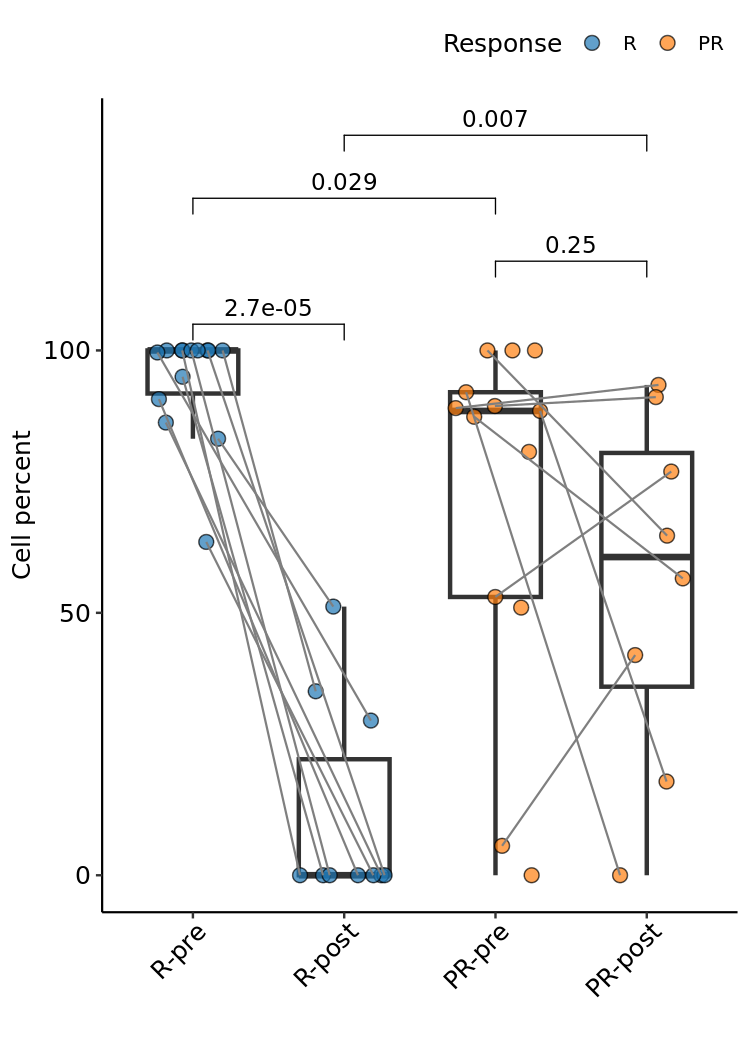

In [ ]:
p <- df %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL,
                      xorder = comb_order, fill_order = gp_lvls[[gp]]) +
    labs(y = 'Cell percent', fill = 'Response') +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.justification = c(1, 0.5))
# ggsave(filename = str_glue('{outdir}/{prefix}-boxplot-cell_pct-{min_cell}.pdf'), plot = p, width = 2.5, height = 5)
p

#### cyto expand clones cross multiple exhau clusters

In [ ]:
prefix <- 'fig4h-cyto_expand_cross_exhau_cluster'
used_clone_cat <- 'Expanded clones in cytotoxic clusters'
min_cell <- 10 # min cell to ensure reliable percent

In [ ]:
# clones selecting
valid_clones <- clone_source %>% 
    filter(clone_cat == used_clone_cat) %>% 
    filter(celltype %in% cell_state_map$exhausted) %>%
    select(clonotype, patient, sample_type, celltype) %>% 
    distinct() %>% 
    count(clonotype, patient, sample_type, name = 'n_ctype_per_sample') %>% 
    filter(n_ctype_per_sample >= n_ctypes)
    # count(clonotype, patient, sample_type, name = 'n_ctype_per_sample') %>%
    # filter(n_ctype_per_sample >= 20)
df <- clone_source %>% 
    filter(clone_cat == used_clone_cat) %>% 
    merge(valid_clones, by = c('clonotype', 'patient', 'sample_type'), all.x = T) %>%
    mutate(is_valid = if_else(is.na(n_ctype_per_sample), 'no', 'yes')) %>%
    count(patient, sample_type, is_valid, name = 'n_cell') %>% 
    pivot_wider(id_cols = c('patient', 'sample_type'), 
                names_from = 'is_valid', 
                values_from = 'n_cell', 
                values_fill = 0) %>% 
    mutate(pct = 100 * yes / (no + yes)) %>%
    filter(no + yes >= min_cell) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient') 
df %>% write_tsv(str_glue('{outdir}/{prefix}-cell_pct-{min_cell}.tsv'))

loginfo('%g samples, %g cells', nrow(df), sum(df$no + df$yes))

2024-02-29 16:56:43 INFO::these clinial info will be added: response
2024-02-29 16:56:43 INFO::55 samples, 17391 cells


In [ ]:
p <- df %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL,
                      xorder = comb_order, fill_order = gp_lvls[[gp]]) +
    labs(y = 'Cell percent', fill = 'Response') +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    theme(legend.justification = c(1, 0.5))
ggsave(filename = str_glue('{outdir}/{prefix}-boxplot-cell_pct-{min_cell}.pdf'), plot = p, width = 2.5, height = 5)
# p

### cell percent of specific cluster in specific clone cat: 4h

- date: 2024-02-29
- desc: cell level

In [ ]:
min_cell <- 10
clone_source <- read_tsv(f_cell_source, show_col_types = F) %>% 
    filter(!grepl('NK', celltype)) 
loginfo('total %g cells, %g samples', nrow(clone_source), length(unique(clone_source$sample)))

2024-03-01 09:46:42 INFO::total 66214 cells, 58 samples


#### exhausted clusters in exhausted contracted

In [ ]:
prefix <- 'fig4h-cell_pct_in_exhau_contract'
used_ctypes <- c('CD8_TYMS', 'T_MKI67')
df <- clone_source %>% 
    filter(clone_cat == 'Contracted clones in exhausted clusters') %>% 
    mutate(cellgp = if_else(celltype %in% used_ctypes, celltype, 'others')) %>% 
    count(patient, sample_type, cellgp, name = 'n_cell') %>% 
    pivot_wider(id_cols = c('patient', 'sample_type'), names_from = 'cellgp',
                values_from = 'n_cell', values_fill = 0) %>% 
    pivot_longer(cols = -c('patient', 'sample_type'), names_to = 'cellgp', values_to = 'n_cell') %>% 
    add_count(patient, sample_type, name = 'n_cell_per_sample', wt = n_cell) %>% 
    mutate(pct = 100 * n_cell / n_cell_per_sample) %>%
    add_clin_info(ftsv = f_pat_gp, columns = gp, merge_by = 'patient')
loginfo('%g records', nrow(df))
df %>% write_tsv(str_glue('{outdir}/{prefix}.tsv'))

2024-03-01 09:51:15 INFO::these clinial info will be added: response
2024-03-01 09:51:15 INFO::147 records


In [ ]:
p_ls <- lapply(X = used_ctypes, function(ctype) {
    df %>%
    filter(n_cell_per_sample >= min_cell) %>%
    filter(cellgp == ctype) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL,
                      xorder = comb_order, fill_order = gp_lvls[[gp]], xangle = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = str_glue('Cell percent of {ctype} in exhausted contracted cells'), fill = 'Response') +
    theme(legend.position = 'right')
})
ggsave(filename = str_glue('{outdir}/{prefix}-{min_cell}.pdf'), width = 4, height = 5,
       plot = wrap_plots(p_ls, ncol = 2, guides = 'collect') & theme(legend.position = 'top'))

## todos

In [ ]:
df <- read_tsv(str_glue('{outdir}/fig4-shannon-post_pre_delta.tsv'), show_col_types = F)

In [ ]:
df %>% filter(subtype == 'CD8_CD74') %>% summarise(.by = 'mandard_group', mean = mean(post_m_pre_index))

mandard_group,mean
<chr>,<dbl>
poor,-0.33287794
good,-0.02441611


# previous fig4 (now fig5)

## pseudo forest plot (fig5)

- **now in fig5**

### functions

In [ ]:
cal_stat <- function(x, y) {
    t_obj <- t.test(x = x, y = y)
    res <- data.frame(
        mean_diff = t_obj$estimate[1] - t_obj$estimate[2],
        conf_int_upper = t_obj$conf.int[2],
        conf_int_lower = t_obj$conf.int[1],
        stderr = t_obj$stderr,
        pval = t_obj$p.value
    )
    return(res)
}

### shannon index

no NK cells, paird patients, delta (good-poor) of post-pre delta index

In [ ]:
f_shanon <- '../../stage4/a03_tcr/diversity/shannon_way2_min10.csv'

df <- read_csv(f_shanon, show_col_types = F) %>%
    mutate(sample = paste(patient, sample_type, sep = '-')) %>%
    filter(!grepl('^NK', subtype))

for (nm in names(celltype_map)) {
    df$subtype[df$subtype %in% celltype_map[[nm]]] <- nm
}
loginfo('%g records, %g samples, %g celltypes', nrow(df), length(unique(df$sample)), length(unique(df$subtype)))

2024-01-04 17:57:24 INFO::1324 records, 80 samples, 18 celltypes


In [ ]:
# post-pre delta
df_delta <- df %>% 
    select(patient, sample_type, subtype, shannon) %>% 
    pivot_wider(names_from = 'sample_type', values_from = 'shannon') %>% 
    filter(!is.na(Baseline), !is.na(Treat)) %>% 
    mutate(post_m_pre_index = Treat - Baseline) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
loginfo('%g records, %g patients, %g celltypes', nrow(df_delta), length(unique(df_delta$patient)), length(unique(df_delta$subtype)))

2024-01-04 17:57:25 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 17:57:25 INFO::411 records, 28 patients, 18 celltypes


In [ ]:
df_delta %>% write_tsv(str_glue('{outdir}/fig4-shannon-post_pre_delta.tsv'))

In [ ]:
# cal stat by subtype
res <- do.call(rbind.data.frame, lapply(X = unique(df$subtype), FUN = function(ctype) {
    cal_stat(x = filter(df_delta, subtype == ctype, mandard_group == 'good') %>% pull(post_m_pre_index),
             y = filter(df_delta, subtype == ctype, mandard_group == 'poor') %>% pull(post_m_pre_index)) %>%
    mutate(subtype = ctype)
}))
# add cell state info
res$cell_state <- 'others'
for (nm in names(cell_state_map)){
    res$cell_state[res$subtype %in% cell_state_map[[nm]]] <- nm
}
loginfo('%g records, %g celltypes', nrow(res), length(unique(res$subtype)))
res %>% write_tsv(str_glue('{outdir}/fig4-shannon-delta_delta-stat.tsv'))

2024-01-04 17:58:28 INFO::18 records, 18 celltypes


In [ ]:
p <- res %>%
    mutate(subtype = factor(subtype, levels = unlist(cell_state_map)), 
           cell_state = factor(cell_state, levels = names(cell_state_map))) %>%
    ggplot(aes(x = mean_diff, y = subtype, color = cell_state, label = subtype)) +
        geom_pointrange(aes(xmin = conf_int_lower, xmax = conf_int_upper), linewidth = 1, size = 1.5, shape = 18) +
        geom_vline(xintercept = 0, color = 'black') +
        geom_text(color = 'black', size = 3.5, nudge_y = 0.3) +
        scale_color_manual(values = cell_state_color) +
        scale_x_reverse() +
        guides(color = guide_legend(ncol = 2, title.position = 'top')) +
        labs(x = 'Delta Shannon Index', y = '', color = 'Cell state') + 
        theme(axis.line.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
ggsave(filename = str_glue('{outdir}/fig4-pseudo_forest-shannon-delta_delta.pdf'), plot = p, width = 2.5, height = 7)

### expansion

no NK cells, paird patients, delta (good-poor) of post-pre delta expand in subtype

In [ ]:
f_expand_diff <- '../../stage4/a03_tcr/expansion/diff_expandPct_min10.csv'

# post-pre delta
df_delta <- read_csv(f_expand_diff, show_col_types = F) %>% 
    filter(!grepl('^NK', subtype)) %>%
    select(patient, subtype, Baseline, Treat, pct_expand_diff) %>%
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')

for (nm in names(celltype_map)) {
    df_delta$subtype[df_delta$subtype %in% celltype_map[[nm]]] <- nm
}
loginfo('%g records, %g patients, %g celltypes', nrow(df_delta), length(unique(df_delta$patient)), length(unique(df_delta$subtype)))

2024-01-04 17:58:53 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 17:58:53 INFO::411 records, 28 patients, 18 celltypes


In [ ]:
df_delta %>% write_tsv(str_glue('{outdir}/fig4-expand_in_subtype-post_pre_delta.tsv'))

In [ ]:
# cal stat by subtype
res <- do.call(rbind.data.frame, lapply(X = unique(df_delta$subtype), FUN = function(ctype) {
    cal_stat(x = filter(df_delta, subtype == ctype, mandard_group == 'good') %>% pull(pct_expand_diff),
             y = filter(df_delta, subtype == ctype, mandard_group == 'poor') %>% pull(pct_expand_diff)) %>%
    mutate(subtype = ctype)
}))
# add cell state info
res$cell_state <- 'others'
for (nm in names(cell_state_map)){
    res$cell_state[res$subtype %in% cell_state_map[[nm]]] <- nm
}
loginfo('%g records, %g celltypes', nrow(res), length(unique(res$subtype)))
res %>% write_tsv(str_glue('{outdir}/fig4-expand_in_subtype-delta_delta-stat.tsv'))

2024-01-04 17:58:55 INFO::18 records, 18 celltypes


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig4-expand_in_subtype-delta_delta-stat.tsv'), show_col_types = F) %>%
    mutate(subtype = factor(subtype, levels = unlist(cell_state_map)), 
           cell_state = factor(cell_state, levels = names(cell_state_map))) %>%
    ggplot(aes(x = mean_diff, y = subtype, color = cell_state, label = subtype)) +
        geom_pointrange(aes(xmin = conf_int_lower, xmax = conf_int_upper), linewidth = 1, size = 1.5, shape = 18) +
        geom_vline(xintercept = 0, color = 'black') +
        geom_text(color = 'black', size = 3.5, nudge_x = -5, nudge_y = 0.3) +
        scale_color_manual(values = cell_state_color) +
        guides(color = guide_legend(ncol = 2, title.position = 'top')) +
        labs(x = bquote(atop(Delta~'expanded cell percent', '(Treat - Baseline)')), y = '', color = 'Cell state') + 
        theme(axis.line.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
ggsave(filename = str_glue('{outdir}/fig4-pseudo_forest-expand_in_subtype-delta_delta.pdf'), plot = p, width = 2.5, height = 7)

## boxplot for CD8_CX3CR1

- date: 2024-01-04
- desc: diversity, diff of expand, expansion percent

In [ ]:
gp <- 'mandard_group'
f_expand <- '../../stage4/a03_tcr/expansion/expand_cell_pct.csv'
f_expand_diff <- '../figures/fig4/fig4-expand_in_subtype-post_pre_delta.tsv'  # this is based on min10 cells results
f_diversity <- '../../stage4/a03_tcr/diversity/shannon_way2_min10.csv'

min_cell_per_sample_subtype <- 10

### expand in cluster

In [ ]:
# process
df <- read_csv(f_expand, show_col_types = F) %>%
    filter(subtype == 'CD8_CX3CR1') %>%
    filter(n_cell_per_sample_subtype >= min_cell_per_sample_subtype) %>%
    select(patient, sample_type, n_expand_cell_per_sample_stype, n_cell_per_sample_subtype,
           pct_in_cluster = pct_by_subtype, pct_in_sample = pct_by_sample) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
loginfo('%g samples for CD8_CX3CR1', nrow(df))
df %>% write_tsv(str_glue('{outdir}/fig4-expand_pct-cd8_cx3cr1-min{min_cell_per_sample_subtype}.tsv'))

2024-01-04 16:14:19 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 16:14:19 INFO::73 samples for CD8_CX3CR1


In [ ]:
# plot
p <- read_tsv(str_glue('{outdir}/fig4-expand_pct-cd8_cx3cr1-min{min_cell_per_sample_subtype}.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct_in_cluster', pt_fill = gp, facet_by = NULL,
                      xorder = NULL, fill_order = gp_lvls[[gp]], xangle = 45) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Expanded cell percent in CD8_CX3CR1', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig4-box_expand-in_cluster-cx3cr1.pdf'), plot = p, width = 3, height = 4.5)

### expand diff in cluster

In [ ]:
p <- read_tsv(f_expand_diff, show_col_types = F) %>% 
    filter(subtype == 'CD8_CX3CR1') %>%
    filter(!is.na(.data[[gp]])) %>% 
    cell_comp_boxplot(x = gp, y = 'pct_expand_diff', pt_fill = gp, pair_by = NULL, facet_by = NULL,
                      xorder = NULL, fill_order = gp_lvls[[gp]], xangle = 45) +
    stat_compare_means(comparisons = gp_comp_diff_map[[gp]]) +
    labs(y = bquote(atop(Delta~'expanded cell percent in CD8_CX3CR1', '(Treat - Baseline)')), fill = 'Response') +
    theme(legend.justification = c(1, 0))
ggsave(filename = str_glue('{outdir}/fig4-box_expand_diff-cx3cr1.pdf'), plot = p, width = 3, height = 4.5)

### diversity: shannon index

In [ ]:
# process
df <- read_csv(f_diversity, show_col_types = F) %>%
    filter(subtype == 'CD8_CX3CR1') %>%
    select(patient, sample_type, shannon) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
loginfo('%g samples for CD8_CX3CR1', nrow(df))
df %>% write_tsv(str_glue('{outdir}/fig4-diversity-cd8_cx3cr1-min{min_cell_per_sample_subtype}.tsv'))

2024-01-04 17:07:32 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 17:07:32 INFO::73 samples for CD8_CX3CR1


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig4-diversity-cd8_cx3cr1-min{min_cell_per_sample_subtype}.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>% 
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'shannon', pt_fill = gp, facet_by = NULL,
                      xorder = NULL, fill_order = gp_lvls[[gp]], xangle = 45) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Shannon index', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig4-box_diversity-cx3cr1.pdf'), plot = p, width = 3, height = 4.5)

## cyto/exhau score by A/B share/specific clones

- date: 2024-01-04
- desc:
  - group cells by TCR sharing type: A/B-share/specific (A = CD8_CX3CR1)
  - cyto/exhau summarise at cell level by TCR sharing type & sample & functional group

In [ ]:
f_info <- '../../stage4/a05_clone_share/a_b_share_old/clone_cat_to_CD8_CX3CR1_per_cell.csv'
gp <- 'mandard_group'
comp_ls <- list(
    c('A-specific', 'A-shared'),
    c('A-shared', 'B-shared'),
    c('B-specific', 'B-shared'),
    c('A-specific', 'B-shared')
)
group_order <- c('A-specific', 'A-shared', 'B-shared', 'B-specific')

In [ ]:
# process
clone_info <- read_csv(f_info, show_col_types = F) %>% 
    filter(!grepl('^NK', compare_with))  # no NK cells
# rename cell types
for (nm in names(celltype_map)) {
    clone_info$subtype[clone_info$subtype %in% celltype_map[[nm]]] <- nm
    clone_info$compare_with[clone_info$compare_with %in% celltype_map[[nm]]] <- nm
}
# add cell state info
clone_info$cell_state <- 'unknown'
for (nm in names(cell_state_map)) {
    clone_info$cell_state[clone_info$compare_with %in% cell_state_map[[nm]]] <- nm
}
clone_info$cell_state[clone_info$cell_state == 'cytotoxic'] <- 'other cytotoxic'
loginfo('%g records', nrow(clone_info))

2024-01-04 19:48:20 INFO::256399 records


In [ ]:
# calculate median score & define as A/B-share/specific
df <- clone_info %>% 
    mutate(rep_ctype = if_else(subtype == 'CD8_CX3CR1', 'A', 'B')) %>% 
    unite(col = 'cell_group', rep_ctype, clone_cat2a, sep = '-', remove = F) %>% 
    summarise(.by = c('sample', 'patient', 'sample_type', 'cell_state', 'cell_group', 'clone_cat2a'),
              exhau_score = median(exhau),
              cyto_score = median(cyto)) %>%
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
df %>% write_tsv(str_glue('{outdir}/fig4-cyto_exhau_score-cell_state.tsv'))
loginfo('%g records after summrizing', nrow(df))

2024-01-04 20:10:34 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 20:10:35 INFO::1183 records after summrizing


In [ ]:
# plot
ylab_map <- list('cyto_score' = 'Cytotoxicity score', 'exhau_score' = 'Exhaustion score')
df <- read_tsv(str_glue('{outdir}/fig4-cyto_exhau_score-cell_state.tsv'), show_col_types = F) %>%
    mutate(cell_state = factor(cell_state, levels = c('other cytotoxic', 'exhausted', 'dying', 'others')),
           cell_group = factor(cell_group, levels = group_order))
p_ls <- lapply(X = names(ylab_map), FUN = function(ycol) {
    ggplot(data = df, aes(x = cell_group, y = .data[[ycol]])) +
    geom_boxplot(aes(fill = clone_cat2a), outlier.shape = NA) +
    geom_jitter(size = 1.5, alpha = 0.5, width = 0.25) +
    facet_wrap(~ cell_state, nrow = 1) +
    stat_compare_means(comparisons = comp_ls) +
    labs(y = ylab_map[[ycol]], fill = 'TCR Shared Type') +
    theme(axis.text.x = element_text(angle = 45, hjust = .95), axis.title.x = element_blank())
})
ggsave(filename = str_glue('{outdir}/fig4-box_cyto_exhau_score-a_b_share.pdf'), 
       plot = wrap_plots(p_ls, ncol = 1, guides = 'collect'), width = 14, height = 9)

## CX3CL1 expression

- date: 2024-01-04

### dotplot in whole data

In [ ]:
scrna <- readRDS('../../stage4/a01_data/seuobj/whole.rds')

In [ ]:
p <- Seurat::DotPlot(scrna, features = 'CX3CL1', group.by = 'cell_type') +
    scale_color_gsea() +
    theme(axis.title = element_blank())
ggsave(filename = str_glue('{outdir}/fig4-dot_exprs-cx3cl1-whole.pdf'), plot = p, width = 4, height = 4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


### pbulk in sample

In [ ]:
f_exprs <- '../../stage4/a04_cx3cl1/tme_exprs/cx3cl1_tme_exprs.tsv'
gp <- 'mandard_group'

In [ ]:
# add clin info
df <- read_tsv(f_exprs, show_col_types = F) %>%
    separate(col = 'sample', into = c('patient', 'sample_type'), sep = '-', remove = F) %>% 
    mutate(cx3cl1_exprs_log = log1p(cx3cl1_exprs_unlog)) %>% 
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
df %>% write_tsv(str_glue('{outdir}/fig4-pbulk_exprs-cx3cl1_in_TME.tsv'))

2024-01-04 22:12:27 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig4-pbulk_exprs-cx3cl1_in_TME.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'cx3cl1_exprs_log', pt_fill = gp, facet_by = NULL,
                      xorder = NULL, fill_order = gp_lvls[[gp]], xangle = 60) + 
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'CX3CL1 expression in sample', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig4-box_exprs-cx3cl1_pbulk_in_TME.pdf'), plot = p, height = 6, width = 4)

## cell composition of CD8_CX3CR1-shared T in T+NK

- date: 2024-01-04
- desc: based on RNA & TCR data

In [ ]:
f_clone_cell <- '../../stage4/a03_tcr/expansion/clone_expand_info_per_cell.csv'
gp <- 'mandard_group'

In [ ]:
clone_info <- read_csv(f_clone_cell, show_col_types = F) %>% 
    filter(!is.na(clonotype))
loginfo('%g cells (RNA & TCR data)', nrow(clone_info))
# define cell
cx3cr1_clones <- clone_info %>% 
    filter(subtype == 'CD8_CX3CR1') %>% 
    pull(clonotype) %>% 
    unique()
loginfo('%g unique CD8_CX3CR1 clones', length(cx3cr1_clones))
# cal fraction
df <- clone_info %>% 
    mutate(cell_group = if_else(clonotype %in% cx3cr1_clones, 'valid', 'others')) %>% 
    add_count(sample, name = 'n_cell_per_sample') %>% 
    filter(subtype != 'CD8_CX3CR1') %>%  # shared TCR with CX3CR1 but not CX3CR1
    count(sample, patient, sample_type, n_cell_per_sample, cell_group, name = 'n_cell') %>% 
    pivot_wider(names_from = 'cell_group', values_from = 'n_cell', values_fill = 0) %>%
    mutate(pct = 100 * valid / n_cell_per_sample) %>%
    select(sample, patient, sample_type, n_valid_cell_per_sample = valid, n_cell_per_sample, pct) %>%
    add_clin_info(ftsv = f_pat_gp, columns = NULL, merge_by = 'patient')
loginfo('%g records', nrow(df))

df %>% write_tsv(str_glue('{outdir}/fig4-cc-non_cx3cr1_with_cx3cr1_tcr-rna_tcr.tsv'))

2024-01-04 22:59:40 INFO::205824 cells (RNA & TCR data)
2024-01-04 22:59:40 INFO::1375 unique CD8_CX3CR1 clones
2024-01-04 22:59:40 INFO::these clinial info will be added: patient_id, mandard_group, response_degree, treatment_group, patient_gp, patient_gp_v2
2024-01-04 22:59:40 INFO::81 records


In [ ]:
p <- read_tsv(str_glue('{outdir}/fig4-cc-non_cx3cr1_with_cx3cr1_tcr-rna_tcr.tsv'), show_col_types = F) %>% 
    filter(!is.na(.data[[gp]])) %>%
    cell_comp_boxplot(x = c(gp, 'sample_type'), y = 'pct', pt_fill = gp, facet_by = NULL, 
                      xorder = NULL, fill_order = gp_lvls[[gp]], xanlge = 60) +
    stat_compare_means(comparisons = gp_comp_map[[gp]]) +
    labs(y = 'Percent of cells share TCR with CD8_CX3CR1\n(exclude CD8_CX3CR1 cells)', fill = 'Response')
ggsave(filename = str_glue('{outdir}/fig4-box_cc-non_cx3cr1_with_cx3cr1_tcr-rna_tcr.pdf'), 
       plot = p, width = 4, height = 6)